# The notebook for requesting the raster geodatasets - cropping images from out S3 bucket to an arbitrary shape and to a bbox from Sentinel-2 and Landsat buckets

In [1]:
%matplotlib inline
import time
from json import load
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import bounds
from rasterio import mask
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import fiona
from sentinelhub import BBox, CRS
# loading libraries for S2 search and managing aws using python
from satsearch import Search
import boto3

ImportError: DLL load failed while importing _base: The specified procedure could not be found.

In [ ]:
path = r'path_to_your.tif'
img = rasterio.open(path)                                                                                                                                  
band = img.read(1)

In [35]:
band.shape

(36000, 72000)

In [22]:
band.shape

(36000, 36000)

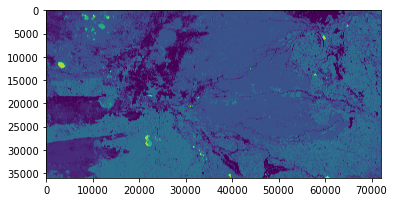

In [36]:
plt.imshow(band)

In [37]:
# we will save our data as files
def converttoraster(array,box,file_name):
    #get shape of new raster
    dst_shape = array.shape
    
    #tranformation requires epsg 3857 so we will convert our bounding box coords to that
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:4326')
    #extract the bounds from our bounding box and use this to create a transformation
    #dst_transform = rasterio.transform.from_origin(*transform(inProj,outProj,*ul),10,10)
    dst_transform = rasterio.transform.from_bounds(*rasterio.coords.BoundingBox(*transform(inProj,outProj,*box.lower_left), *transform(inProj,outProj,*box.upper_right)),width=dst_shape[1], height=dst_shape[0])
    
    
    # Write it out to a file.
    with rasterio.open(file_name, 'w', driver='GTiff',
                                  width=dst_shape[1], height=dst_shape[0],
                                  count=1, dtype=np.float64, nodata=float('nan'),
                                  transform=dst_transform, crs='EPSG:4326') as dst:
        dst.write(array.astype(np.float64), indexes=1)

In [3]:
# Initialising the aws session
aws_session = rasterio.session.AWSSession(boto3.Session(), requester_pays=True)
# reading data from our buckets. Credentials needed to be set up.
s3 = boto3.resource('s3')

In [2]:
# reading data from our buckets
for bucket in s3.buckets.all():
    print(bucket.name)

NameError: name 's3' is not defined

### Requesting and clipping the tif image from our S3 bucket!
By boundaries of geojson

In [ ]:
# Set the path to geojson
inshp = 'path_to_your.geojson'                                                         
fp = 'path_to_your_cog_on_s3_bucket.tif'
#fp = 'https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2021/170/032/LE07_L2SP_170032_20210604_20210630_02_T1/LE07_L2SP_170032_20210604_20210630_02_T1_SR_B3.TIF'

print("Loading Mask...")
#read in the buffered shapefile using fiona
with fiona.open(inshp, "r") as shapefile:                                                                                                                       
    shapes = [feature["geometry"] for feature in shapefile]                                                                                                     
                                                                                                                                                                
#Using rasterio, read directly from the SRTM VRT of COGs, and crop
# data to the buffer polygon
print("Extracting SRTM to mask...")
with rasterio.open(fp) as src:                                                                                                                                  
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)                                                                                       
    out_meta = src.meta

Loading Mask...
Extracting SRTM to mask...


In [11]:
"""
# Alternatively, you can define the bbox manually
def BuildSquare(lon, lat, delta):
    c1 = [lon + delta, lat + delta]
    c2 = [lon + delta, lat - delta]
    c3 = [lon - delta, lat - delta]
    c4 = [lon - delta, lat + delta]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

geometry = BuildSquare(-59.346271, -34.233076, 0.04)
"""

### Searching entire S2 scenes touching the boundaries

In [ ]:
file_path = "path_to_your_boundary_file.geojson"
file_content = load(open(file_path))
geometry = file_content["features"][0]["geometry"]

timeRange = '2021-06-01/2021-06-30'

In [17]:
# Setting up the Sentinel search parameters and collections for the bbox from the geojson boundaries
SentinelSearch = Search.search( 
    url = "https://earth-search.aws.element84.com/v0",
    intersects = geometry,
    datetime = timeRange,
    collections = ['sentinel-s2-l2a-cogs'] )

# requesting all images covering the bbox
Sentinel_items = SentinelSearch.items()
print(Sentinel_items.summary())

for item in Sentinel_items:
    red_s3 = item.assets['B04']['href']
    print(red_s3)

Items (12):
date                      id                        
2021-06-30                S2A_38TMK_20210630_0_L2A  
2021-06-28                S2B_38TMK_20210628_0_L2A  
2021-06-25                S2B_38TMK_20210625_0_L2A  
2021-06-23                S2A_38TMK_20210623_0_L2A  
2021-06-20                S2A_38TMK_20210620_0_L2A  
2021-06-18                S2B_38TMK_20210618_0_L2A  
2021-06-15                S2B_38TMK_20210615_0_L2A  
2021-06-13                S2A_38TMK_20210613_0_L2A  
2021-06-10                S2A_38TMK_20210610_0_L2A  
2021-06-08                S2B_38TMK_20210608_0_L2A  
2021-06-05                S2B_38TMK_20210605_0_L2A  
2021-06-03                S2A_38TMK_20210603_0_L2A  

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/38/T/MK/2021/6/S2A_38TMK_20210630_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/38/T/MK/2021/6/S2B_38TMK_20210628_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l

### Preparing the function of subsetting and needed transformation

In [18]:
from pyproj import Transformer

def getSubset(geotiff_file, bbox):
    with rasterio.Env(aws_session):
        with rasterio.open(geotiff_file) as geo_fp:
            # Calculate pixels with PyProj 
            Transf = Transformer.from_crs("epsg:4326", geo_fp.crs) 
            lat_north, lon_west = Transf.transform(bbox[3], bbox[0])
            lat_south, lon_east = Transf.transform(bbox[1], bbox[2]) 
            x_top, y_top = geo_fp.index( lat_north, lon_west )
            x_bottom, y_bottom = geo_fp.index( lat_south, lon_east )
            # Define window in RasterIO
            window = rasterio.windows.Window.from_slices( ( x_top, x_bottom ), ( y_top, y_bottom ))                
            # Actual HTTP range request
            subset = geo_fp.read(1, window=window)
    return subset

In [19]:
# The function for NDVI calcs and plotting the picture with saving 
def plotNDVI(nir,red,filename):
    ndvi = (nir-red)/(nir+red)
    ndvi[ndvi>1] = 1
    plt.imshow(ndvi)
    plt.savefig(filename)
    plt.close()

### Requesting the images and subsetting parts of the image by bbox 

In [22]:
bbox = bounds(geometry)
box = BBox(bbox,crs=CRS.WGS84)

for i,item in enumerate(Sentinel_items):
    red_s3 = item.assets['B04']['href']
    nir_s3 = item.assets['B08']['href']
    date = item.properties['datetime'][0:10]
    print("Sentinel item number " + str(i) + "/" + str(len(Sentinel_items)) + " " + date)
    red = getSubset(red_s3, bbox)
    nir = getSubset(nir_s3, bbox)
    break
    #plotNDVI(nir,red, "_ndvi.png")

Sentinel item number 0/12 2021-06-30


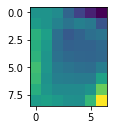

In [23]:
# Visualising the result
plt.subplot(2, 2, 1)
plt.imshow(red)
plt.imshow(nir)
plt.show()

In [29]:
# Saving
converttoraster(red,box,'example.tif')

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

### Searching entire Landsat scenes touching the boundaries

In [ ]:
# Set the path to geojson and indicate needed dates
file_path = "path_to_your_boundary_file.geojson"
file_content = load(open(file_path))
geometry = file_content["features"][0]["geometry"]

timeRange = '2021-06-01/2021-06-30'

In [7]:
from pystac_client import Client
LandsatSTAC = Client.open("https://landsatlook.usgs.gov/stac-server", headers=[])
for collection in LandsatSTAC.get_collections():
    print(collection)

<CollectionClient id=landsat-c2l2-sr>
<CollectionClient id=landsat-c2l2-st>
<CollectionClient id=landsat-c2ard-st>
<CollectionClient id=landsat-c2l2alb-bt>
<CollectionClient id=landsat-c2l3-fsca>
<CollectionClient id=landsat-c2ard-bt>
<CollectionClient id=landsat-c2l1>
<CollectionClient id=landsat-c2l3-ba>
<CollectionClient id=landsat-c2l2alb-st>
<CollectionClient id=landsat-c2ard-sr>
<CollectionClient id=landsat-c2l2alb-sr>
<CollectionClient id=landsat-c2l2alb-ta>
<CollectionClient id=landsat-c2l3-dswe>
<CollectionClient id=landsat-c2ard-ta>


In [8]:
LandsatSearch = LandsatSTAC.search ( 
    intersects = geometry,
    datetime = timeRange,
    query =  ['eo:cloud_cover95'],
    collections = ["landsat-c2l2-sr"] )

Landsat_items = [i.to_dict() for i in LandsatSearch.get_items()]
print(f"{len(Landsat_items)} Landsat scenes fetched")

3 Landsat scenes fetched


In [33]:
# Obtaining the url paths to the entire scenes, covering our shp
for item in Landsat_items:
    red_href = item['assets']['red']['href']
    red_s3 = item['assets']['red']['alternate']['s3']['href']

    print(red_href)    
    print(red_s3)
    
    red1 = getSubset(red_s3, bbox)

https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2021/170/032/LC08_L2SP_170032_20210628_20210707_02_T1/LC08_L2SP_170032_20210628_20210707_02_T1_SR_B4.TIF
s3://usgs-landsat/collection02/level-2/standard/oli-tirs/2021/170/032/LC08_L2SP_170032_20210628_20210707_02_T1/LC08_L2SP_170032_20210628_20210707_02_T1_SR_B4.TIF
https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2021/170/032/LC08_L2SP_170032_20210612_20210622_02_T1/LC08_L2SP_170032_20210612_20210622_02_T1_SR_B4.TIF
s3://usgs-landsat/collection02/level-2/standard/oli-tirs/2021/170/032/LC08_L2SP_170032_20210612_20210622_02_T1/LC08_L2SP_170032_20210612_20210622_02_T1_SR_B4.TIF
https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2021/170/032/LE07_L2SP_170032_20210604_20210630_02_T1/LE07_L2SP_170032_20210604_20210630_02_T1_SR_B3.TIF
s3://usgs-landsat/collection02/level-2/standard/etm/2021/170/032/LE07_L2SP_170032_20210604_20210630_02_T1/LE07_L2SP_170032_20210604_20210630_02_T1_

In [32]:
converttoraster(red1,box,'example1.tif')

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi